# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [30]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [31]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [32]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [33]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

Attribute Information:

Id Company Identifier 
- X1 net profit / total assets
- X2 total liabilities / total assets
- X3 working capital / total assets
- X4 current assets / short-term liabilities
- X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
- X6 retained earnings / total assets
- X7 EBIT / total assets
- X8 book value of equity / total liabilities
- X9 sales / total assets
- X10 equity / total assets
- X11 (gross profit + extraordinary items + financial expenses) / total assets
- X12 gross profit / short-term liabilities
- X13 (gross profit + depreciation) / sales
- X14 (gross profit + interest) / total assets
- X15 (total liabilities * 365) / (gross profit + depreciation)
- X16 (gross profit + depreciation) / total liabilities
- X17 total assets / total liabilities
- X18 gross profit / total assets
- X19 gross profit / sales
- X20 (inventory * 365) / sales
- X21 sales (n) / sales (n-1)
- X22 profit on operating activities / total assets
- X23 net profit / sales
- X24 gross profit (in 3 years) / total assets
- X25 (equity - share capital) / total assets
- X26 (net profit + depreciation) / total liabilities
- X27 profit on operating activities / financial expenses
- X28 working capital / fixed assets
- X29 logarithm of total assets
- X30 (total liabilities - cash) / sales
- X31 (gross profit + interest) / sales
- X32 (current liabilities * 365) / cost of products sold
- X33 operating expenses / short-term liabilities
- X34 operating expenses / total liabilities
- X35 profit on sales / total assets
- X36 total sales / total assets
- X37 (current assets - inventories) / long-term liabilities
- X38 constant capital / total assets
- X39 profit on sales / sales
- X40 (current assets - inventory - receivables) / short-term liabilities
- X41 total liabilities / ((profit on operating activities + depreciation) * (12/365))
- X42 profit on operating activities / sales
- X43 rotation receivables + inventory turnover in days
- X44 (receivables * 365) / sales
- X45 net profit / inventory
- X46 (current assets - inventory) / short-term liabilities
- X47 (inventory * 365) / cost of products sold
- X48 EBITDA (profit on operating activities - depreciation) / total assets
- X49 EBITDA (profit on operating activities - depreciation) / sales
- X50 current assets / total liabilities
- X51 short-term liabilities / total assets
- X52 (short-term liabilities * 365) / cost of products sold)
- X53 equity / fixed assets
- X54 constant capital / fixed assets
- X55 working capital
- X56 (sales - cost of products sold) / sales
- X57 (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)
- X58 total costs /total sales
- X59 long-term liabilities / equity
- X60 sales / inventory
- X61 sales / receivables
- X62 (short-term liabilities *365) / sales
- X63 sales / short-term liabilities
- X64 sales / fixed assets

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [35]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [36]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import math

In [37]:
# Convert all data values to numeric, coercing errors to NaN
data = data.applymap(pd.to_numeric, errors='coerce')
holdout_data = holdout_data.applymap(pd.to_numeric, errors='coerce')

# Replace '?' with NaN to handle missing values
data.replace('?', np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Fill missing values with column-wise mean
holdout_data.replace('?', np.nan, inplace=True)
holdout_data.fillna(holdout_data.mean(), inplace=True)

# Convert DataFrame to NumPy array
df = data.values
out = holdout_data.values

# Display summary statistics of the dataset
data.describe()

# Extract features (all columns except last two) and normalize them
X=df[:, :-2]
X = StandardScaler().fit_transform(X) # Standardize features for ML models

# Extract target variable (second last column)
y=df[:, -2]
# Alternative feature and target extraction using Pandas indexing
X_data=data.iloc[:,:-2]
y_data=data.iloc[:, -2]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
count,4818.000000,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,...,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927,3499.858032
std,6.705958,1.202660,1.282164,100.117705,2.382015e+04,7.776908,6.706577,109.348749,1.342723,4.043196,...,7.247517,0.932427,6.337285,6.942383e+04,43.766529,2279.713700,113.049493,583.617986,0.244648,1392.049260
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000,1071.000000
25%,0.004042,0.254765,0.044978,1.101525,-4.290075e+01,0.000000,0.005977,0.482350,1.015600,0.319095,...,0.015582,0.876940,0.000000,5.456550e+00,4.236425,45.065750,3.077000,2.137425,0.000000,2296.250000
50%,0.046428,0.451610,0.218155,1.645450,4.932050e-01,0.000000,0.056653,1.154350,1.140500,0.522195,...,0.108860,0.950825,0.006365,9.449650e+00,6.181450,73.879500,4.939500,4.224000,0.000000,3500.500000
75%,0.116725,0.662140,0.420033,2.943000,4.978025e+01,0.110387,0.135972,2.814600,1.814050,0.721670,...,0.240200,0.990358,0.208242,1.968150e+01,9.342925,118.597500,8.097875,9.834275,0.000000,4704.750000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000,5909.000000


Handling Missing Data:
 - Linear Regression Imputation: for data which shows linear trends
 
        Train a linear regression model on the available data 
        Predict missing values using the trained model 
        Replace missing values with predicted values

 - Interpolation (when missing is between values)
    
        For each missing value: 
        Find the nearest known data points (x1, y1) and (x2, y2) 
        Compute slope: m = (y2 - y1) / (x2 - x1) 
        Estimate missing value: y = y1 + m * (x - x1) 
        Replace missing value with estimated y

 - Extrapolation (time-series forecasting)
 
        Select the two most recent known data points (x1, y1) and (x2, y2)
        Compute slope: m = (y2 - y1) / (x2 - x1)
        For each missing value:
        Predict missing value: y = y2 + m * (x - x2)
        Replace missing value with estimated y

Can be used in ECM to find missing values

Visualize data, and find that the data is imbalanced, and the features have high correlation.

<AxesSubplot:>

Text(0.5, 1.0, 'Not Bankrupt(0) vs Bankrupt(1)')

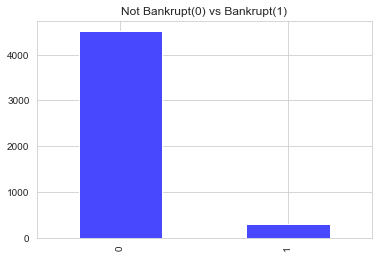

In [38]:
import seaborn as sns
y_data.value_counts().plot(kind='bar')
sns.set_style('whitegrid')
sns.set_palette('bwr')
plt.title('Not Bankrupt(0) vs Bankrupt(1)')
plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1118500.,  -821640.,  -524780.,  -227920.,    68940.,   365800.,
          662660.,   959520.,  1256380.,  1553240.,  1850100.,  2146960.,
         2443820.,  2740680.,  3037540.,  3334400.,  3631260.,  3928120.,
         4224980.,  4521840.,  4818700.]),
 <a list of 66 BarContainer objects>)

Text(0.5, 0, 'bankrupt')

Text(0.5, 1.0, 'Histogram of Data')

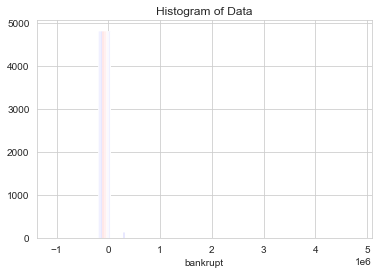

In [39]:
plt.hist(data, bins=20, alpha=0.5)
plt.xlabel('bankrupt')
plt.title('Histogram of Data')
plt.show()

Heatmap

<AxesSubplot:>

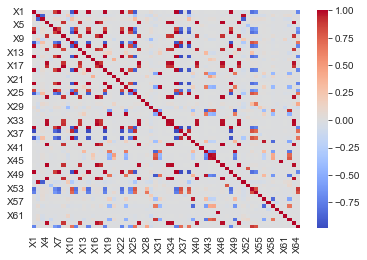

In [40]:
corr_matrix = X_data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

Here I use randomoversampler to do random oversampling, and use PCA to lower the dimenision since we have dataset with features having high correlation with each other.

In [41]:
from imblearn.over_sampling import RandomOverSampler
# Random oversampling
# ros = RandomOverSampler(random_state=42)
# X_ros, y_ros = ros.fit_resample(X, y)

# SMOTE

I also try SMOTE to balance the data to avoid overfitting. After applying SMOTE we can find the recall and precision seems to be balanced.

In [42]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_ros, y_ros = smote.fit_resample(X, y)
# X_ros, y_ros = X, y

# PCA

array([[-0.34702704, -0.5294126 , -0.12070425],
       [-0.21829935, -0.92479567, -0.04201198],
       [-0.33985283, -0.5397412 , -0.10783738],
       ...,
       [-0.33001267, -0.63287133, -0.10503977],
       [-0.64097052,  5.50196878,  0.01719111],
       [-0.4842435 ,  2.82453163, -0.05874605]])

array([[-0.34702704, -0.5294126 , -0.12070438, -0.21890147],
       [-0.21829935, -0.92479567, -0.04201217, -0.08630401],
       [-0.33985283, -0.5397412 , -0.10783738, -0.16917528],
       ...,
       [-0.33001267, -0.63287133, -0.10503985, -0.1439246 ],
       [-0.64097052,  5.50196878,  0.01719123, -0.33927063],
       [-0.4842435 ,  2.82453162, -0.05874581,  0.33723778]])

array([[-0.34702704, -0.5294126 , -0.12070438, -0.21890142, -0.09078046],
       [-0.21829935, -0.92479567, -0.04201213, -0.08630391, -0.1116826 ],
       [-0.33985283, -0.5397412 , -0.1078374 , -0.16917524, -0.09423035],
       ...,
       [-0.33001267, -0.63287133, -0.10503985, -0.14392457, -0.09838916],
       [-0.64097052,  5.50196878,  0.01719121, -0.3392706 , -0.11634401],
       [-0.4842435 ,  2.82453162, -0.05874585,  0.3372377 , -0.10826811]])

array([[-0.34702704, -0.5294126 , -0.12070436, -0.21890151, -0.09078079,
        -0.16843691],
       [-0.21829935, -0.92479567, -0.04201213, -0.08630403, -0.11168368,
        -0.02324083],
       [-0.33985283, -0.5397412 , -0.10783739, -0.16917528, -0.09423056,
         0.02857552],
       ...,
       [-0.33001267, -0.63287133, -0.10503984, -0.14392462, -0.09838908,
        -0.0407661 ],
       [-0.64097052,  5.50196878,  0.01719122, -0.3392706 , -0.11634366,
         0.22480096],
       [-0.4842435 ,  2.82453162, -0.05874584,  0.33723786, -0.1082671 ,
         0.31957855]])

array([[-0.34702704, -0.52941152, -0.12070582, ..., -0.09069363,
        -0.16838103, -0.05180104],
       [-0.21829935, -0.92479457, -0.04201248, ..., -0.11156463,
        -0.02321977, -0.16223063],
       [-0.33985283, -0.53974069, -0.10783863, ..., -0.09420623,
         0.02857533, -0.12456415],
       ...,
       [-0.33001267, -0.63287063, -0.10503958, ..., -0.09831334,
        -0.04070869, -0.11989409],
       [-0.64097052,  5.50196879,  0.01718846, ..., -0.11633413,
         0.22479334,  0.01421847],
       [-0.4842435 ,  2.82452993, -0.05874647, ..., -0.10843698,
         0.31955811, -0.22328372]])

array([[-0.34702704, -0.52941217, -0.12070547, ..., -0.16840826,
        -0.0516725 , -0.98861729],
       [-0.21829935, -0.92479468, -0.04202241, ..., -0.02320347,
        -0.16190954, -1.05565715],
       [-0.33985283, -0.53974106, -0.10783569, ...,  0.02856602,
        -0.12449943, -0.83542915],
       ...,
       [-0.33001267, -0.63287099, -0.10504298, ..., -0.04072086,
        -0.11979495, -0.91344152],
       [-0.64097052,  5.50196898,  0.01718749, ...,  0.22480831,
         0.01447529,  1.42598842],
       [-0.4842435 ,  2.82453044, -0.0587353 , ...,  0.31948628,
        -0.22358277,  0.66963607]])

array([[-0.34702704, -0.52941184, -0.12071414, ..., -0.05184039,
        -0.9879401 , -0.11695997],
       [-0.21829935, -0.92479546, -0.04201795, ..., -0.16241924,
        -1.05590039,  0.16336827],
       [-0.33985283, -0.5397409 , -0.1078411 , ..., -0.12461724,
        -0.83478354,  0.02496574],
       ...,
       [-0.33001267, -0.632871  , -0.1050426 , ..., -0.11988511,
        -0.91317791,  0.07383392],
       [-0.64097052,  5.5019687 ,  0.01719255, ...,  0.01438648,
         1.42594908,  0.10426376],
       [-0.4842435 ,  2.82453081, -0.05873365, ..., -0.22305071,
         0.66980317,  0.9844791 ]])

array([[-0.34702704, -0.52941152, -0.12068638, ..., -0.98968519,
        -0.11455539,  0.07205302],
       [-0.21829935, -0.92479519, -0.04199731, ..., -1.05776778,
         0.16321592,  0.13596791],
       [-0.33985283, -0.53974073, -0.10783172, ..., -0.83520468,
         0.02708917, -0.06715291],
       ...,
       [-0.33001267, -0.63287095, -0.1050271 , ..., -0.91481255,
         0.0735555 ,  0.04465396],
       [-0.64097052,  5.50196838,  0.01719186, ...,  1.42576494,
         0.10285736,  0.00725891],
       [-0.48424351,  2.82453024, -0.05876872, ...,  0.67204428,
         0.98176761,  0.06801808]])

array([[-3.47027039e-01, -5.29412701e-01, -1.20707685e-01, ...,
        -1.13990533e-01,  6.32047969e-02, -2.35985047e-02],
       [-2.18299347e-01, -9.24795711e-01, -4.20144524e-02, ...,
         1.65110644e-01,  1.26526939e-01, -2.70426003e-02],
       [-3.39852832e-01, -5.39741638e-01, -1.07839214e-01, ...,
         2.70287823e-02, -7.23088278e-02, -2.00324118e-02],
       ...,
       [-3.30012669e-01, -6.32871282e-01, -1.05041416e-01, ...,
         7.45702448e-02,  4.27638660e-02, -2.23761959e-02],
       [-6.40970518e-01,  5.50196900e+00,  1.71922687e-02, ...,
         1.03193317e-01,  1.05165873e-02, -2.11614624e-03],
       [-4.84243502e-01,  2.82453110e+00, -5.87427692e-02, ...,
         9.81869242e-01,  7.76882510e-02,  1.01022536e-02]])

array([[-3.47027040e-01, -5.29413392e-01, -1.20704488e-01, ...,
         6.78604835e-02, -1.89120927e-02, -1.53913347e-01],
       [-2.18299348e-01, -9.24795808e-01, -4.20115200e-02, ...,
         1.33668598e-01, -1.81120630e-02, -1.90475648e-01],
       [-3.39852832e-01, -5.39741591e-01, -1.07836856e-01, ...,
        -7.08908195e-02, -1.83790230e-02, -9.39864370e-02],
       ...,
       [-3.30012669e-01, -6.32871594e-01, -1.05039905e-01, ...,
         4.63963789e-02, -1.81434352e-02, -1.18672025e-01],
       [-6.40970518e-01,  5.50196906e+00,  1.71913240e-02, ...,
         1.27643536e-02, -8.29755640e-04, -5.35791812e-02],
       [-4.84243500e-01,  2.82453244e+00, -5.87453308e-02, ...,
         7.04635166e-02,  3.50468950e-03,  4.11577514e-02]])

array([[-3.47027039e-01, -5.29412313e-01, -1.20705965e-01, ...,
        -2.26600349e-02, -1.55762744e-01,  6.15865160e-02],
       [-2.18299349e-01, -9.24796107e-01, -4.20080432e-02, ...,
        -1.68511977e-02, -1.84110368e-01,  5.13905505e-02],
       [-3.39852832e-01, -5.39741136e-01, -1.07837062e-01, ...,
        -2.17298360e-02, -9.64268453e-02, -7.04362431e-02],
       ...,
       [-3.30012669e-01, -6.32871211e-01, -1.05040949e-01, ...,
        -1.91095585e-02, -1.19288131e-01,  2.91937879e-02],
       [-6.40970518e-01,  5.50196875e+00,  1.71908838e-02, ...,
        -1.10654644e-03, -5.49928242e-02, -2.17339643e-01],
       [-4.84243502e-01,  2.82453124e+00, -5.87430880e-02, ...,
         6.43041491e-03,  3.87308698e-02, -2.48000286e-01]])

array([[-0.34702704, -0.52941255, -0.12070833, ..., -0.15728071,
         0.02883744, -0.21979349],
       [-0.21829935, -0.92479567, -0.04201276, ..., -0.19052882,
         0.07068802, -0.28208962],
       [-0.33985283, -0.53974118, -0.10783909, ..., -0.09580724,
        -0.08245464, -0.10616417],
       ...,
       [-0.33001267, -0.6328713 , -0.10504114, ..., -0.11979637,
         0.01238959, -0.16240776],
       [-0.64097052,  5.50196881,  0.01719371, ..., -0.05049806,
        -0.20978501,  0.02328813],
       [-0.4842435 ,  2.82453157, -0.05874217, ...,  0.04175214,
        -0.21597802,  0.26211789]])

array([[-0.34702704, -0.52941255, -0.12070324, ...,  0.03529072,
        -0.22349299, -0.08710926],
       [-0.21829935, -0.92479565, -0.04201173, ...,  0.06950169,
        -0.28656526, -0.12300786],
       [-0.33985283, -0.53974115, -0.10783619, ..., -0.08172645,
        -0.10995362, -0.04098972],
       ...,
       [-0.33001267, -0.63287133, -0.10503985, ...,  0.01504303,
        -0.16378756, -0.07749723],
       [-0.64097052,  5.5019687 ,  0.01718955, ..., -0.21222377,
         0.02560274, -0.09184066],
       [-0.4842435 ,  2.8245316 , -0.05874643, ..., -0.22130536,
         0.2659719 ,  0.03389071]])

array([[-0.34702704, -0.52941261, -0.12070434, ..., -0.21766363,
        -0.09087779,  0.32773153],
       [-0.21829935, -0.92479567, -0.04201213, ..., -0.28182055,
        -0.12567289,  0.55029817],
       [-0.33985283, -0.5397412 , -0.10783737, ..., -0.10537614,
        -0.04305441,  0.13374561],
       ...,
       [-0.33001267, -0.63287133, -0.10503983, ..., -0.16165918,
        -0.0790481 ,  0.21015302],
       [-0.64097052,  5.50196882,  0.01719127, ...,  0.02190157,
        -0.08918959,  0.05556709],
       [-0.4842435 ,  2.82453161, -0.05874583, ...,  0.26128831,
         0.03646914, -0.56554894]])

array([[-3.47027039e-01, -5.29412605e-01, -1.20704382e-01, ...,
        -9.02900665e-02,  3.27314010e-01, -1.46531905e-03],
       [-2.18299348e-01, -9.24795664e-01, -4.20120824e-02, ...,
        -1.26071288e-01,  5.50024757e-01,  1.02497558e-01],
       [-3.39852831e-01, -5.39741199e-01, -1.07837373e-01, ...,
        -4.31362529e-02,  1.33478425e-01,  1.47635884e-02],
       ...,
       [-3.30012669e-01, -6.32871330e-01, -1.05039843e-01, ...,
        -7.90201695e-02,  2.10047880e-01, -2.01088079e-02],
       [-6.40970518e-01,  5.50196879e+00,  1.71912441e-02, ...,
        -9.07472944e-02,  5.66257545e-02, -9.17425945e-03],
       [-4.84243501e-01,  2.82453162e+00, -5.87458746e-02, ...,
         3.72967248e-02, -5.65621767e-01, -4.42749936e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704356e-01, ...,
         3.27072741e-01, -9.45645558e-04,  1.47862530e-01],
       [-2.18299348e-01, -9.24795668e-01, -4.20121233e-02, ...,
         5.50325023e-01,  1.01547016e-01, -2.11151385e-02],
       [-3.39852831e-01, -5.39741202e-01, -1.07837390e-01, ...,
         1.33679480e-01,  1.44937191e-02,  2.44815703e-02],
       ...,
       [-3.30012669e-01, -6.32871329e-01, -1.05039834e-01, ...,
         2.10049179e-01, -1.98178250e-02,  1.13741894e-01],
       [-6.40970518e-01,  5.50196878e+00,  1.71912077e-02, ...,
         5.67686679e-02, -9.55230881e-03, -2.91370871e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458277e-02, ...,
        -5.65864102e-01, -4.30899376e-02, -3.09323521e-01]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704355e-01, ...,
        -9.68672885e-04,  1.47881454e-01, -6.79635376e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121177e-02, ...,
         1.01630902e-01, -2.13780437e-02, -9.09855201e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837392e-01, ...,
         1.43947234e-02,  2.44433577e-02, -5.91350916e-03],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039837e-01, ...,
        -1.99385414e-02,  1.13796435e-01, -7.01776617e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912126e-02, ...,
        -9.61278766e-03, -2.93348364e-02, -1.95948687e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458425e-02, ...,
        -4.32110225e-02, -3.08845028e-01,  1.25815059e-01]])

array([[-0.34702704, -0.5294126 , -0.12070435, ...,  0.14794778,
        -0.06804272, -0.0225128 ],
       [-0.21829935, -0.92479567, -0.04201212, ..., -0.02145218,
        -0.0909128 , -0.01683706],
       [-0.33985283, -0.5397412 , -0.10783739, ...,  0.02441697,
        -0.00588438, -0.02774547],
       ...,
       [-0.33001267, -0.63287133, -0.10503984, ...,  0.1138504 ,
        -0.07024307,  0.01632809],
       [-0.64097052,  5.50196878,  0.01719123, ..., -0.02956396,
        -0.01926903, -0.00615809],
       [-0.4842435 ,  2.82453162, -0.05874586, ..., -0.30880669,
         0.12566749, -0.0294781 ]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -6.80766143e-02, -2.24514656e-02, -7.80793109e-03],
       [-2.18299348e-01, -9.24795669e-01, -4.20121157e-02, ...,
        -9.08618741e-02, -1.68877898e-02, -7.23247062e-03],
       [-3.39852831e-01, -5.39741201e-01, -1.07837389e-01, ...,
        -5.90250992e-03, -2.77283854e-02, -1.39391598e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -7.02465931e-02,  1.63480613e-02, -4.27911862e-03],
       [-6.40970518e-01,  5.50196878e+00,  1.71912228e-02, ...,
        -1.94001292e-02, -6.04504932e-03, -1.01539876e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458325e-02, ...,
         1.25590895e-01, -2.93639121e-02, -1.36349126e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704359e-01, ...,
        -2.24777153e-02, -7.77473219e-03, -3.73306686e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121137e-02, ...,
        -1.68292161e-02, -7.26874154e-03, -5.73806496e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
        -2.77592611e-02, -1.39195537e-02, -1.14532123e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
         1.63475140e-02, -4.26600138e-03, -4.48980916e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912177e-02, ...,
        -6.18696572e-03, -1.00705366e-02, -1.26082428e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458418e-02, ...,
        -2.95771540e-02, -1.34608894e-02,  4.89701912e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -7.75477064e-03, -3.73503383e-02, -2.96131659e-01],
       [-2.18299348e-01, -9.24795669e-01, -4.20121143e-02, ...,
        -7.30649664e-03, -5.73761810e-02, -8.10226750e-03],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
        -1.39038060e-02, -1.14449959e-02, -1.57133330e-01],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -4.26364259e-03, -4.49053738e-02, -8.53320749e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912195e-02, ...,
        -9.96433939e-03, -1.26239272e-02,  8.04136582e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458436e-02, ...,
        -1.34339171e-02,  4.90711159e-02,  3.43036146e-01]])

array([[-0.34702704, -0.5294126 , -0.12070436, ..., -0.03734555,
        -0.29614723,  0.07262294],
       [-0.21829935, -0.92479567, -0.04201211, ..., -0.05738175,
        -0.00808992,  0.03595344],
       [-0.33985283, -0.5397412 , -0.10783739, ..., -0.01144433,
        -0.15713842,  0.0056305 ],
       ...,
       [-0.33001267, -0.63287133, -0.10503984, ..., -0.04490532,
        -0.08534005,  0.04580888],
       [-0.64097052,  5.50196878,  0.01719122, ..., -0.01261491,
         0.08038327, -0.05180601],
       [-0.4842435 ,  2.82453162, -0.05874584, ...,  0.04907918,
         0.34305087, -0.03882076]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -2.96146000e-01,  7.26211490e-02, -6.39383055e-04],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
        -8.08852351e-03,  3.59516595e-02,  2.39886668e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
        -1.57137185e-01,  5.62888764e-03,  1.09016683e-01],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -8.53363806e-02,  4.58038483e-02, -1.60481643e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
         8.03841430e-02, -5.18057357e-02, -2.81198342e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
         3.43032946e-01, -3.87941851e-02,  1.42995130e-01]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
         7.26216505e-02, -6.38784528e-04,  3.91916933e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
         3.59504970e-02,  2.39892299e-02, -7.31931143e-03],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         5.62730514e-03,  1.09016602e-01,  1.54375084e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
         4.58021148e-02, -1.60470982e-02, -3.28422476e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912178e-02, ...,
        -5.18153814e-02, -2.81111995e-02, -1.83624423e-01],
       [-4.84243501e-01,  2.82453162e+00, -5.87458430e-02, ...,
        -3.87877246e-02,  1.42992054e-01,  5.59547840e-03]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -6.38635112e-04,  3.91967582e-02,  6.93801452e-03],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
         2.39875504e-02, -7.32936378e-03, -8.65999645e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         1.09014684e-01,  1.54233193e-02,  9.57918477e-03],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -1.60497535e-02, -3.28578506e-02, -2.55504414e-03],
       [-6.40970518e-01,  5.50196878e+00,  1.71912180e-02, ...,
        -2.81205164e-02, -1.83727739e-01,  1.17982732e-01],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
         1.43001464e-01,  5.66293449e-03, -9.36241354e-03]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
         3.91953131e-02,  6.93839516e-03,  5.42084322e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
        -7.32952656e-03, -8.65988922e-02, -5.09713860e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         1.54240185e-02,  9.57958459e-03, -2.72225356e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -3.28582851e-02, -2.55364255e-03,  3.57058815e-03],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
        -1.83705461e-01,  1.17989957e-01, -1.99722376e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
         5.66289354e-03, -9.36290299e-03,  4.37752257e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
         6.93805311e-03,  5.42085520e-02, -4.13733375e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
        -8.65991769e-02, -5.09743080e-02,  5.16093653e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         9.57952809e-03, -2.72250255e-02,  3.18592866e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -2.55412122e-03,  3.56598553e-03, -2.51511577e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
         1.17989592e-01, -1.99826449e-02,  8.99546899e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
        -9.36183212e-03,  4.37670591e-02, -7.72994243e-02]])

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Total explained variance')

Text(0.5, 1.0, 'Total explained variance per components')

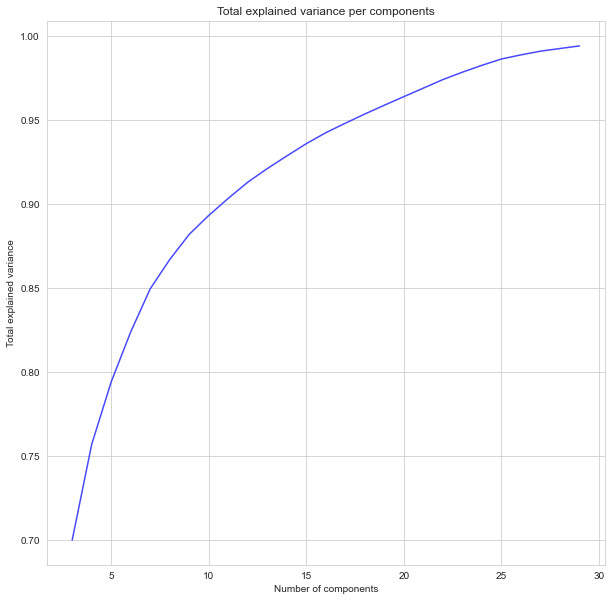

In [43]:
# Deciding the number of components for PCA
temp = []
n_components = np.arange(3,30)
for n in n_components:
    pca = PCA(n_components = n)
    pca.fit_transform(X_ros)
    total_variance = pca.explained_variance_ratio_.sum()
    temp.append(total_variance)

sns.set_style('whitegrid')
sns.set_palette('bwr')
plt.figure(figsize = (10,10))
plt.plot(n_components, temp)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.title('Total explained variance per components')
plt.show()

1. Create an empty list to store explained variance
2. Loop through different numbers of principal components
   - a. Initialize PCA with 'n' components
   - b. Fit PCA to the dataset and transform it
   - c. Calculate the total explained variance
   - d. Store the explained variance in the list
3. Plot the number of components against the total explained variance

In ECM, PCA can be used to identify key risk factors affecting economic capital.

Stress Testing: PCA can identify major risk drivers that contribute to capital adequacy.

Portfolio Risk Management: Helps group correlated financial metrics, improving model robustness.

We can see from the plot that the first 15 components have already explained 92% variance.

In [44]:
scaler = StandardScaler()
X_scaled_ros = scaler.fit_transform(X_ros)
pca = PCA(n_components=15)
X_pca_ros = pca.fit_transform(X_scaled_ros)

# SVM

Since gridsearch takes quite a long time, I use randomsearch instead.

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn import svm
from sklearn.svm import SVC
 
# Define the hyperparameter search space for SVM
param_dist = {'C': [1, 10, 20], # Regularization Strength, control trade-off between achieving a low error on training data 
                                # and maintaining model generalization
              'gamma': [0.1, 0.5], # Kernel coefficient for RBF Kernel, control influence of individual training points on
                                   # decision boundaries
              'kernel': ['linear', 'rbf']} # Choice of Kernel Function, determine how the SVM separates data in feature space

# Initialize an SVM model with a default linear kernel
svm = svm.SVC(kernel='linear')
n_iter_search = 10
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=n_iter_search, cv=5)
# random search helps find the best combination of hyperparameters for a machine learning model.
# Fit Randomized Search to the resampled dataset
random_search.fit(X_ros, y_ros)
print("Best hyperparameters: {}".format(random_search.best_params_))
print("Best score: {:.2f}".format(random_search.best_score_))

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear'),
                   param_distributions={'C': [1, 10, 20], 'gamma': [0.1, 0.5],
                                        'kernel': ['linear', 'rbf']})

Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.5, 'C': 20}
Best score: 0.95


In [46]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
print("SVM")

# Initialize an SVM model with specified hyperparameters
svm_model=SVC(C=20, gamma=0.5)
# Split dataset into training (90%) and testing (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_ros, y_ros, test_size=0.1, random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

SVM


SVC(C=20, gamma=0.5)

In [47]:
name = "SVM model"

# Evaluate model performance
accuracy_test = accuracy_score(y_test, svm_pred)
recall_test = recall_score(y_test, svm_pred, pos_label=1, average="binary")# Ability to detect bankrupt companies
precision_test = precision_score(y_test,   svm_pred, pos_label=1, average="binary", zero_division=1)

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	SVM model Accuracy: 83.7%, Recall 84.3%, Precision 83.0%


1. Initialize SVM model with hyperparameters: (depends on cases)
   - C = 20 (higher regularization, reducing misclassification penalties)
   - gamma = 0.5 (higher sensitivity to individual data points)
2. Split dataset into training (90%) and testing (10%) sets.
3. Train SVM model using the training set.
4. Make predictions on the test set.
5. Compute model evaluation metrics:
   - Accuracy: Overall classification correctness
   - Recall: Measures how well bankrupt companies are identified
   - Precision: Measures correctness of bankruptcy predictions
6. Print model performance results.
7. Compute and visualize confusion matrix to analyze prediction errors. 

For ECM:

Can be used to identify firms at higher financial risk

Adjust parameters of SVM (c and gamma) to improve accuracy of default probability (Apply RandomizedSearchCV)

<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for SVM')

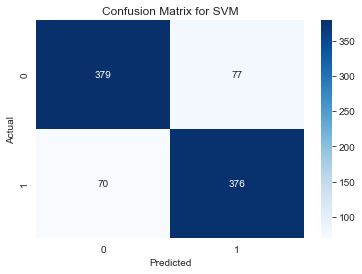

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

# Logistic Regression

Logistic Regression


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

	Logistic Regression Model Accuracy: 75.4%, Recall 70.9%, Precision 77.5%


<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

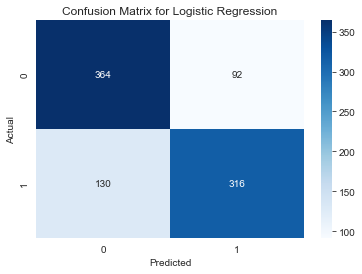

In [49]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
print("Logistic Regression")

# Initialize Logistic Regression with balanced class weights to handle class imbalance
log_reg = LogisticRegression(
    solver='lbfgs', # Solver for optimization (default, works well for small-medium datasets)      
    max_iter=5000,  # Increase max iterations to ensure convergence      
    class_weight='balanced',  # Adjusts weights to balance class distribution
    random_state=42
)

# Train the model on the training set
log_reg.fit(X_train, y_train)  
# Predict on the test set
log_reg_pred = log_reg.predict(X_test)  

# Evaluate model performance
accuracy_log_reg = accuracy_score(y_test, log_reg_pred)
recall_log_reg = recall_score(y_test, log_reg_pred, pos_label=1, average="binary")
precision_log_reg = precision_score(y_test, log_reg_pred, pos_label=1, average="binary")

name = "Logistic Regression Model"
print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(
    m=name, a=accuracy_log_reg, r=recall_log_reg, p=precision_log_reg
))

# Compute and visualize confusion matrix
cm = confusion_matrix(y_test, log_reg_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

1. Initialize Logistic Regression with:
   - 'lbfgs' solver for optimization
   - max_iter=5000 to prevent convergence issues
   - class_weight='balanced' to handle imbalanced bankruptcy data
2. Train the model using training data (X_train, y_train).

3. Predict bankruptcy probabilities for test data (X_test).

4. Compute model performance metrics:
   - Accuracy: Overall model correctness
   - Recall: Ensures bankrupt companies are correctly identified
   - Precision: Measures correctness of bankruptcy predictions

5. Print model evaluation results.

6. Compute confusion matrix to analyze classification errors.

7. Visualize confusion matrix using a heatmap.

For ECM:

Interpretable Model: Coefficients represent the impact of financial ratios on bankruptcy probability.

Helps in probability-based economic capital allocation.

# Neural network model

In [50]:
from sklearn.metrics import classification_report
print("Neural network")
print("iteration : 50000")
logistic_activation = MLPClassifier(activation = 'logistic', # Uses sigmoid activation function
                                    hidden_layer_sizes = (90,90,3), # Three-layer neural network structure
                                    solver = "sgd", # Uses stochastic gradient descent optimizer
                                    random_state=1, max_iter=50000)

# Train the neural network model
logistic_activation.fit(X_train, y_train)
# Predict on the test set
logis_pred = logistic_activation.predict(X_test)
score_logis = accuracy_score(logis_pred, y_test)
print("sigmoid activation function test accuracy:", score_logis)

Neural network
iteration : 50000


MLPClassifier(activation='logistic', hidden_layer_sizes=(90, 90, 3),
              max_iter=50000, random_state=1, solver='sgd')

sigmoid activation function test accuracy: 0.4911308203991131


In [51]:
name = "Neural network model"

# Evaluate model performance
accuracy_test = accuracy_score(y_test, logis_pred)
recall_test = recall_score(y_test, logis_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   logis_pred, pos_label=1, average="binary", zero_division=1)

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	Neural network model Accuracy: 49.1%, Recall 99.3%, Precision 49.3%


1. Initialize a Neural Network (MLPClassifier) with:
   - Sigmoid activation function ('logistic')
   - Three hidden layers: 90, 90, 3 neurons
   - Stochastic Gradient Descent (SGD) optimizer
   - max_iter=50000 to ensure full convergence

2. Train the model using training data (X_train, y_train).

3. Predict bankruptcy outcomes for test data (X_test).

4. Compute performance metrics:
   - Accuracy: Overall correctness of predictions
   - Recall: Ability to correctly classify bankrupt companies
   - Precision: Accuracy of bankruptcy predictions

5. Print model evaluation results.

For ECM:

Handles nonlinear relationship in financial data

Sigmoid activation (logistic) is useful for probabilistic bankruptcy classification

<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for Neural Network')

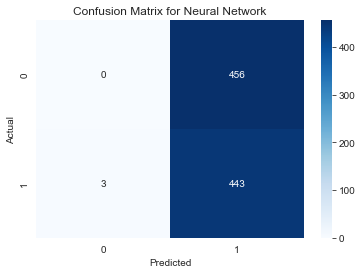

In [52]:
cm = confusion_matrix(y_test, logis_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Neural Network')
plt.show()

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

# Decision Tree

In [53]:
import pandas as pd
import os

def MyModel(X):
    model = tree.DecisionTreeClassifier(
    max_depth=10, # Limit tree depth to avoid excessive complexity
    min_samples_split=10, # Require at least 10 samples to split a node
    min_samples_leaf=5, # Require at least 5 samples per leaf node
    random_state=42)
    model = model.fit(X_train, y_train)
    
    predictions = model.predict(X)
    return predictions

In [54]:
#random_out=holdout_data.iloc[:, :-1]
#X_test=random_out.sample(n=482,axis='rows')

In [55]:
name = "My best model---Decision tree model: "
y_test_pred = MyModel(X_test)

# Evaluate model performance
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test, y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	My best model---Decision tree model:  Accuracy: 85.7%, Recall 90.1%, Precision 82.5%


1. Initialize a Decision Tree classifier with:
   - max_depth=10 (prevent overfitting)
   - min_samples_split=10 (ensure splits happen on sufficiently large nodes)
   - min_samples_leaf=5 (ensure leaf nodes are not too small)

2. Train the decision tree model on the training dataset (X_train, y_train).

3. Predict bankruptcy status for given input data (X).

4. Compute and return predictions.

5. Test the model using X_test and evaluate:
   - Accuracy (percentage of correct predictions)
   - Recall (how well bankrupt firms are identified)
   - Precision (correctness of bankruptcy predictions)

6. Print model performance results.

For ECM:
Easy to visualize decision rules, help to find whichi financial metrics drive bankruptcy risk

<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for Decision tree')

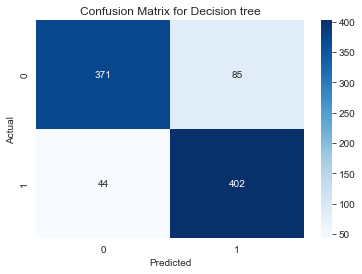

In [56]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision tree')
plt.show()

I choose decision tree as my best model as its recall and precision are more in line with my expectation.
As we know that "You may assume that it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt", it indicates that we should have the recall higher than precision when trying to make trade-off between Recall and Precision. I set the test size to be small in order to achive this goal which larger proportion of the data will be used for training the model. Thus the model has more training data to learn from and can better capture the patterns in the data that are associated with the positive class. However, SVM model and neural network model fail to achieve this goal. I try to increase the penalty parameter of the error term of SVM model "c", but even I increase to 20000 recall is still smaller than precision. 

### Decision Tree

Advantages:

- Easy to interpret and visualize.
- Captures non-linear relationships.
- Works well with small datasets and categorical variables.

Disadvantages:

- Prone to overfitting, especially with deep trees.
- Sensitive to noisy data.
- Not as effective for high-dimensional data without boosting or bagging.

### Neural Network (MLP)

Advantages:

- Excellent for capturing complex, non-linear patterns.
- Works well with large datasets and high-dimensional data.
- Can model financial risk factors that interact in non-trivial ways.

Disadvantages:
- Hard to interpret (black-box model).
- Requires high computational power and tuning.
- Prone to overfitting if not properly regularized.

### Logistic Regression

Advantages:

- Simple, interpretable, and easy to implement.
- Works well for linearly separable data.
- Computationally efficient, even for large datasets.

Disadvantages:
- Assumes linear relationships, which may not hold for complex financial data.
- Struggles with imbalanced data without resampling techniques.
- Less powerful compared to tree-based models or deep learning.

### Support Vector Machine (SVM)

Advantages:

- Works well with small and medium-sized datasets.
- Effective for high-dimensional data.
- Can handle non-linear classification with the right kernel.

Disadvantages:
- Computationally expensive for large datasets.
- Hard to interpret compared to logistic regression or decision trees.
- Requires tuning of C and gamma to avoid overfitting or underfitting.

ECM:

Suggest for logistic regression (easy, interpretable) Neural network (For Complex Risk Patterns)

A single Decision Tree can easily memorize training data instead of learning general patterns (since variables for ECM interact in complex way)

SVM is quite expensive in large dataset